In [1]:
from granad import core, wrappers
import jax.numpy as jnp
import jax
import numpy as np
import matplotlib.pyplot as plt

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Setting up external electric field (illumination)

In this notebook, we will learn how to set up external electric fields, performing simulations on previously created stacks.

**Contents of this notebook:**   
Example 3.1. Set up and plot an electric field\
Example 3.2. Different types of fields

----------------------------

External illumination constitutes an important factor in the simulations and research in the field os electrooptics, which is why we will shortly introduce how they are modeled in our system.

What is more, GRANAD has been devised with the concept of convenience in mind; hence, except for the purely mathematical/physical parts, it is equipped with a body of simple, ready-to-use wrappers. One of those constitute simulations.

### Example 3.1. Set up and plot electric fields

External illumination must be defined as one of the previously mentioned types:
- continuous wave (`plane_wave`)
- Gaussian pulse (`plane_wave_pulse`)
- dipolar source (`dipole_field`)
- `plane_wave_with_ramp_up`

Firstly, based on the the Gaussian pulse illumination example, we will become acquainted with the `show_electric_field_space()` wrapper function, which shows the external electric field on a spatial grid at a fixed point in time.\
As per documentation, it takes in:
- `first`, `second` - grid coordinates, which get passed directly as meshgrid(frist, second)
- `plane`- which plane to use for field evaluation
- `time` - time to evalute the field at
- `field_func` - a function taking in parameters as given by args and an additional argument "positions" that produces a closure that gives the electric field as function of time
- `args` - arguments for the `field_func` in the form of a dictionary (with the `positions` argument omitted)
- `component` - 0 => plot x (default), 1 => plot y, 2 => plot z
- `flag` - 0 => plot real (default), 1 => plot imag, 2 => plot abs

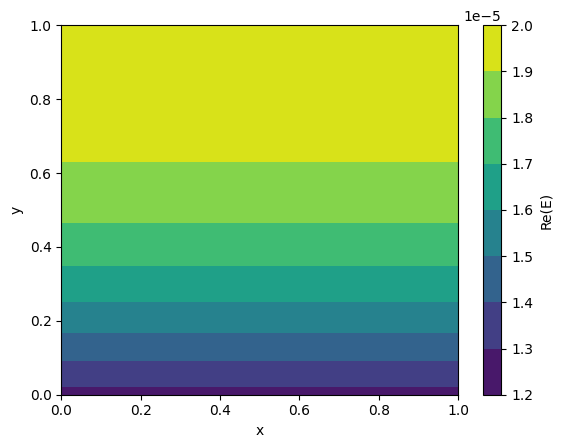

In [2]:
first = second = jnp.linspace(0, 1, 50)
plane = 'xy'
time = 5
field_func = core.plane_wave_pulse
args = {
    "k_vector" : [0, 1, 0],
    "amplitudes" : [0.01],
    "frequency" : 5, 
    #"positions" - will be generated from the parameters above
    "peak" : 2,
    "fwhm" : 2
    }
wrappers.show_electric_field_space(first, second, plane, time, field_func, args, component=0, flag=0)

Now, we can analyze a more complex example, starting with the familiar process of setting up our basic graphene geometry:

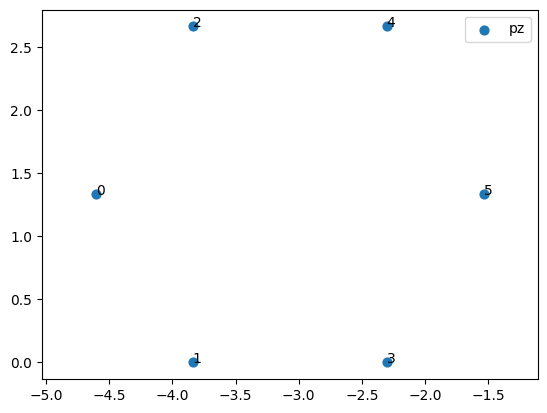

/home/julia/.local/lib/python3.10/site-packages/matplotlib/axes/_axes.py:4411: ComplexWarning: Casting complex values to real discards the imaginary part
  c = np.asanyarray(c, dtype=float)


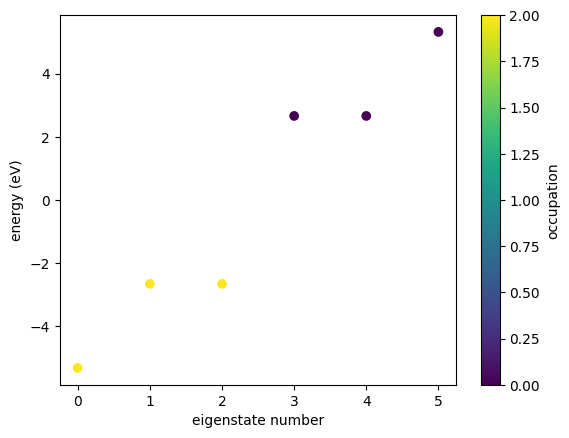

In [3]:
cc_distance = -2.66 / np.sqrt(3)
graphene_armchair_unit = wrappers.unit_cells['armchair'] * cc_distance
graphene_armchair_scale = wrappers.scales['armchair'] * cc_distance
orbs = core.get_orbitals(core.triangle(1), graphene_armchair_unit, graphene_armchair_scale, 'pz', shift = jnp.zeros(3))

orbs_in_uc = cc_distance * jnp.array(
    [
        [0, 0, 0],
        [1, 0, 0],
        [-1 / 2, -jnp.sqrt(3) / 2, 0],
        [-1 / 2, -jnp.sqrt(3) / 2, 0],
    ]
)
hopping = core.neighbour_coupling( graphene_armchair_unit, orbs_in_uc, [0, -2.66 + 0j])
coulomb = core.neighbour_coupling( graphene_armchair_unit, orbs_in_uc, [16.522 + 0j, 8.64 + 0j, 5.333 + 0j], lambda r :  27.21*0.52918/r + 0j)
h_dict = { ('pz', 'pz') : hopping }
c_dict = { ('pz', 'pz') : coulomb }
stack = core.get_stack(orbs, h_dict, c_dict)

wrappers.show_eigenstate2D(stack, indicate_size = False)
wrappers.show_energies(stack)

We can now use it to conduct a simulation based on its geometrical and energetical structure.

/home/julia/Github/GRANAD-1.0/tests/utils/flake.py:36: UserWarning: For the selected flake shape only the width is important, the length will not be considered.
  warnings.warn('For the selected flake shape only the width is important, the length will not be considered.')
/home/julia/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


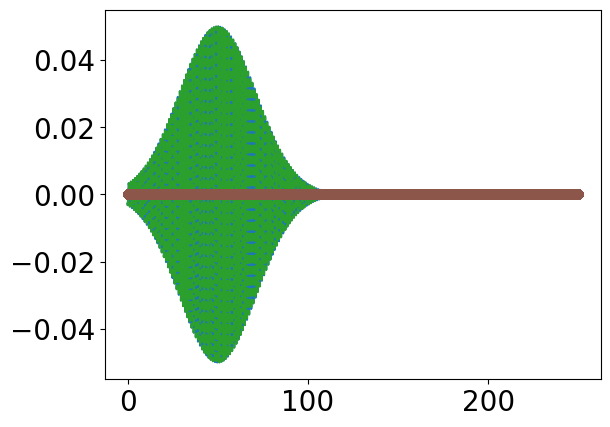

In [4]:
from sys import path
import os
os.chdir(os.path.dirname(path[0]))

from utils.categories import Edge, Shape, Illumination
from utils.field import Field
from utils.flake import Flake
from utils.evolution import Evolution

flake_params = {'shape': Shape.TRIANGLE, 'width_in_nm': 0.5, 'length_in_nm': 0.5, 'edge_type': Edge.ARMCHAIR, 'verbose': False}
field_params = {'illumination_type' : Illumination.PULSE, 'frequency': 2, 'amplitude': 0.05, 'polarization_angle': 0, 'peak' : 50, 'fwhm' : 50}
evolution_params = {'end_time': 250, 'number_of_timesteps': 1_500_000, 'stationary_state': 0, 'equilibrium_state': 0, 'use_rwa': True, 'is_induced_on_adatom': True}
flake_1 = Flake(**flake_params)
evolution_1 = Evolution(**evolution_params)

excited_idx, ground_idx = 3,2
field_params['frequency'] = flake_1.energies[excited_idx] - flake_1.energies[ground_idx]
field_1 = Field(evolution_1.time_axis, **field_params)

field = core.plane_wave_pulse(jnp.array([0, 0, 1]), jnp.array([field_params['amplitude'], 0, 0]), stack.energies[stack.homo + 1] - stack.energies[stack.homo], stack.positions, peak = field_params['peak'], fwhm =  field_params['fwhm'] )
f1 = jax.vmap(lambda t : field(t)[:,0], (0,), 0)( evolution_1.time_axis[::10])

plt.plot(evolution_1.time_axis[::10], f1[:, :2])
plt.plot(evolution_1.time_axis[::10], field_1.get_electric_field()[:, ::10].T, '--')
plt.plot(evolution_1.time_axis[::10], np.abs(f1[:, :2] - field_1.get_electric_field()[:, ::10].T), 'o')
plt.show()

Now, in turn, we will focus on the analogous `show_electric_field_time()` method, which shows the external electric field with its (x,y,z)-components as a function of time at a fixed spatial point.\
It requires less data:
- `time` - array of points in time for field evaluation
- `field` - output of an electric field function
- `flag` - 0 => plot real (default), 1 => plot imag, 2 => plot abs

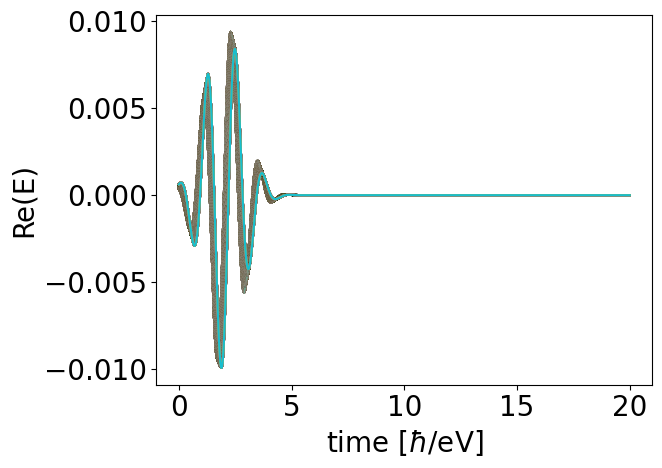

In [5]:
k_vector = [0, 1, 0]
amplitudes = [0.01]
frequency = 5

plane_indices = jnp.array([0, 1, 2])
x = y = jnp.linspace(0, 1, 50)
x, y = jnp.meshgrid(x, y)
dim = x.size
positions = jnp.concatenate(
    (
        jnp.stack((x, y), axis=2).reshape(dim, 2),
        jnp.expand_dims(jnp.zeros(dim), 1),
    ),
    axis=1,
)[:, plane_indices]


peak = 2
fwhm = 2

field = core.plane_wave_pulse(k_vector, amplitudes, frequency, positions, peak, fwhm)

time = jnp.linspace(0, 20, 2500)

wrappers.show_electric_field_time(time, field, flag=0)

### Example 3.2. Different types of fields

Moving on, we shall shortly showcase the other possible illumination types.

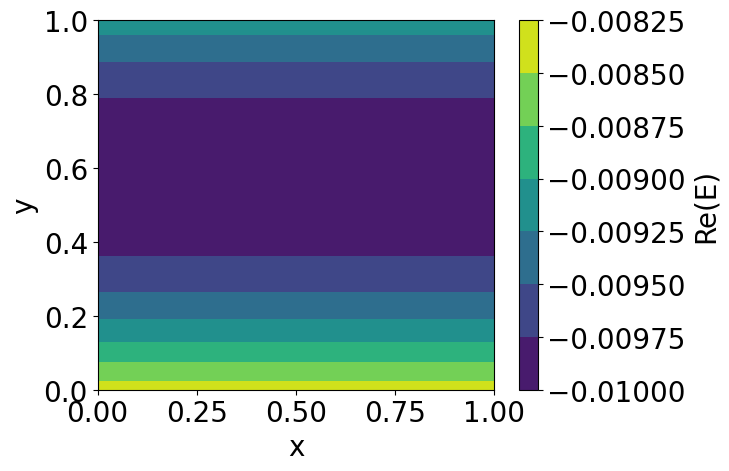

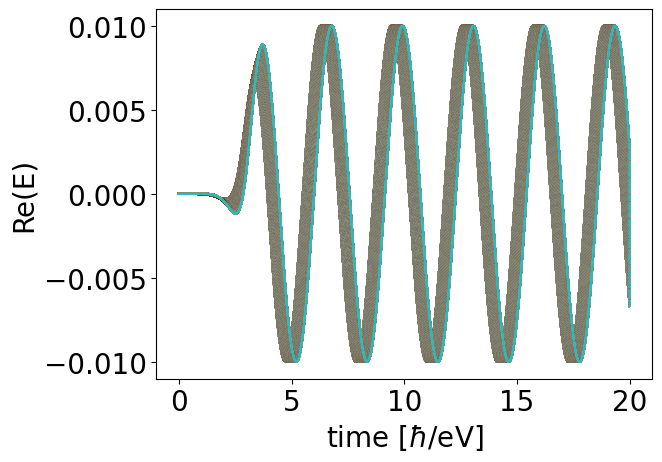

In [6]:
# CONTINUOUS WAVE WITH RAMP

# Plot in space
first = second = jnp.linspace(0, 1, 50)
plane = 'xy'
time = 5
field_func = core.plane_wave_with_ramp_up
args = {
    "k_vector" : [0, 1, 0],
    "amplitudes" : [0.01],
    "frequency" : 2,
    "ramp_duration" : 3,
    "time_ramp" : 3
    }

wrappers.show_electric_field_space(first, second, plane, time, field_func, args, component=0, flag=0)


# Plot in time
k_vector = [0, 1, 0]
amplitudes = [0.01]
frequency = 2

plane_indices = jnp.array([0, 1, 2])
x = y = jnp.linspace(0, 1, 50)
x, y = jnp.meshgrid(x, y)
dim = x.size
positions = jnp.concatenate(
    (
        jnp.stack((x, y), axis=2).reshape(dim, 2),
        jnp.expand_dims(jnp.zeros(dim), 1),
    ),
    axis=1,
)[:, plane_indices]

ramp_duration = 3
time_ramp = 3

field = core.plane_wave_with_ramp_up(k_vector, amplitudes, frequency, positions, ramp_duration, time_ramp)

time = jnp.linspace(0, 20, 2500)

wrappers.show_electric_field_time(time, field, flag=0)

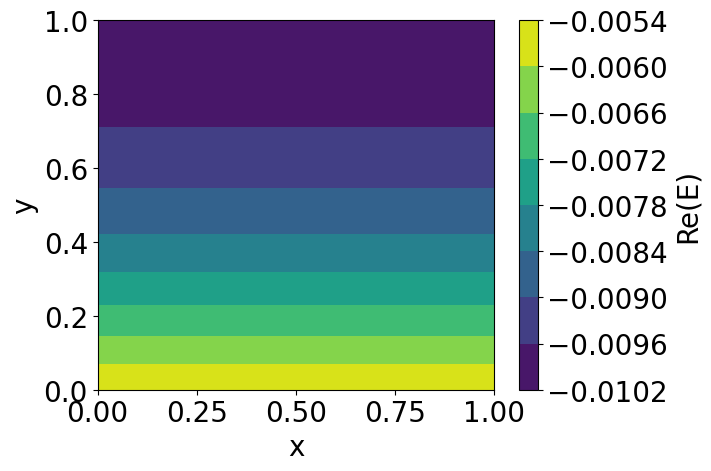

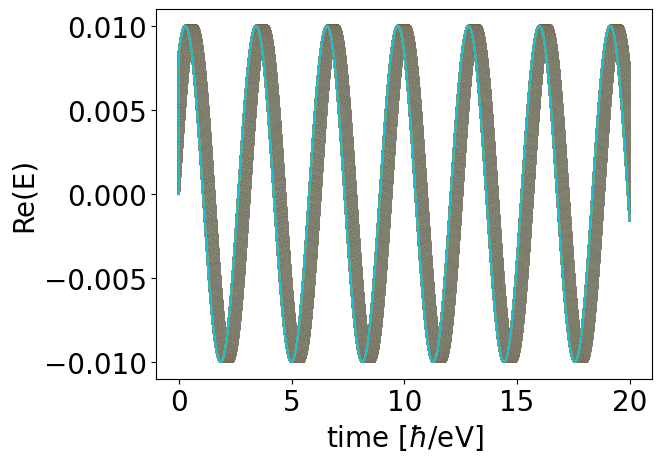

In [7]:
# CONTINUOUS WAVE

# Plot in space
first = second = jnp.linspace(0, 1, 50)
plane = 'xy'
time = 5
field_func = core.plane_wave
args = {
    "k_vector" : [0, 1, 0],
    "amplitudes" : [0.01],
    "frequency" : 2
    }

wrappers.show_electric_field_space(first, second, plane, time, field_func, args, component=0, flag=0)


# Plot in time
k_vector = [0, 1, 0]
amplitudes = [0.01]
frequency = 2

plane_indices = jnp.array([0, 1, 2])
x = y = jnp.linspace(0, 1, 50)
x, y = jnp.meshgrid(x, y)
dim = x.size
positions = jnp.concatenate(
    (
        jnp.stack((x, y), axis=2).reshape(dim, 2),
        jnp.expand_dims(jnp.zeros(dim), 1),
    ),
    axis=1,
)[:, plane_indices]


field = core.plane_wave(k_vector, amplitudes, frequency, positions)

time = jnp.linspace(0, 20, 2500)

wrappers.show_electric_field_time(time, field, flag=0)

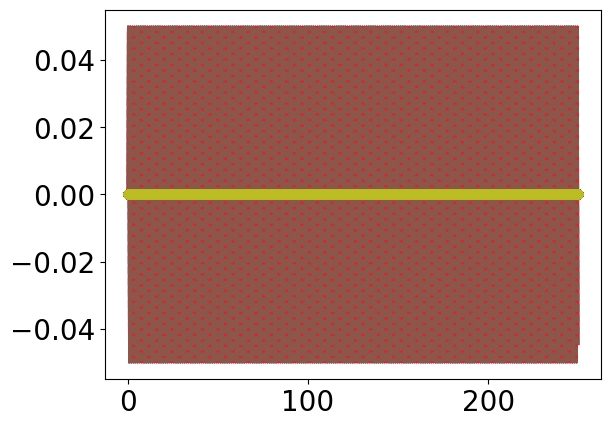

In [8]:
# CONTINUOUS WAVE based on flake-data

flake_params = {'shape': Shape.TRIANGLE, 'width_in_nm': 0.5, 'length_in_nm': 0.5, 'edge_type': Edge.ARMCHAIR, 'verbose': False}
field_params = {'illumination_type' : Illumination.CW, 'frequency': 2, 'amplitude': 0.05, 'polarization_angle': 0}
evolution_params = {'end_time': 250, 'number_of_timesteps': 1_500_000, 'stationary_state': 0, 'equilibrium_state': 0, 'use_rwa': True, 'is_induced_on_adatom': True}

flake_1 = Flake(**flake_params)
evolution_1 = Evolution(**evolution_params)

cc_distance = -2.66 / np.sqrt(3) 
graphene_armchair_unit = wrappers.unit_cells['armchair'] * cc_distance
graphene_armchair_scale = wrappers.scales['armchair'] * cc_distance
orbs = core.get_orbitals(core.triangle(1), graphene_armchair_unit, graphene_armchair_scale, 'pz', shift = jnp.zeros(3))

orbs_in_uc = cc_distance * jnp.array(
    [
        [0, 0, 0],
        [1, 0, 0],
        [-1 / 2, -jnp.sqrt(3) / 2, 0],
        [-1 / 2, -jnp.sqrt(3) / 2, 0],
    ]
)
hopping = core.neighbour_coupling( graphene_armchair_unit, orbs_in_uc, [0, -2.66 + 0j])
coulomb = core.neighbour_coupling( graphene_armchair_unit, orbs_in_uc, [16.522 + 0j, 8.64 + 0j, 5.333 + 0j], lambda r :  27.21*0.52918/r + 0j)
h_dict = { ('pz', 'pz') : hopping }
c_dict = { ('pz', 'pz') : coulomb }
stack = core.get_stack( orbs, h_dict, c_dict )

excited_idx, ground_idx = 3,2
field_params['frequency'] = flake_1.energies[excited_idx] - flake_1.energies[ground_idx]
field_1 = Field(evolution_1.time_axis, **field_params)

field = core.plane_wave( jnp.array([0,0,1]), jnp.array([field_params['amplitude'], 0, 0]), stack.energies[stack.homo+1]-stack.energies[stack.homo], stack.positions )
f1 = jax.vmap( lambda t : field(t)[:,0], (0,), 0)( evolution_1.time_axis[::10])
np.testing.assert_allclose( f1[:,:2], field_1.get_electric_field()[:,::10].T )

plt.plot( evolution_1.time_axis[::10], f1 )
plt.plot( evolution_1.time_axis[::10], f1[:,:2])
plt.plot( evolution_1.time_axis[::10], field_1.get_electric_field()[:,::10].T, '--')
plt.plot( evolution_1.time_axis[::10], np.abs(f1[:,:2] - field_1.get_electric_field()[:,::10].T), 'o')
plt.show()

As it differs from the others, to demonstrate the dipole illumination, we need to first get a set of coordinates where the field will be evaluated, since in this case the electric field depends not only on time but also on the location in real-space. Thus, we will first construct a flake and then use its coordinates as the coordinates where the field should be evaluated.\
For this purpose, we can create a stack and use it.

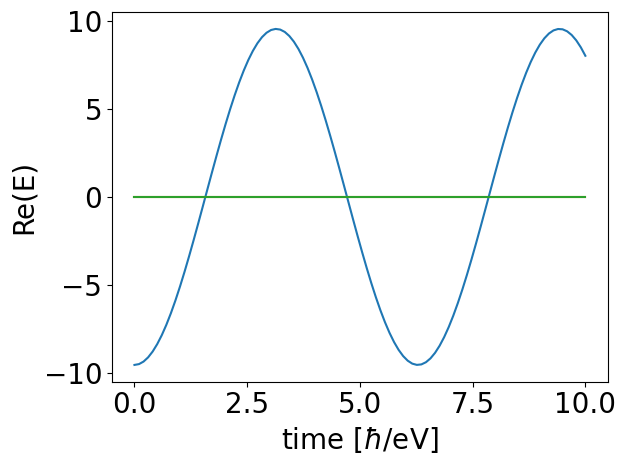

In [9]:
# DIPOLE FIELD

f = core.dipole_field([core.Dipole([0,0,0], [1,0,0], 1)], jnp.array([[10,0,0]]))

wrappers.show_electric_field_time(jnp.linspace(0,10,100), f)

In [11]:
position = [2, 4, 0]
moment = [2, 4, 0]
frequency = 2

dipole = [core.Dipole(position, moment, frequency)]

cc_distance = -2.66 / np.sqrt(3) 
graphene_zigzag_unit = wrappers.unit_cells['zigzag'] * cc_distance
graphene_zigzag_scale = wrappers.scales['zigzag'] * cc_distance
orbs = core.get_orbitals(core.hexagon(3, 5), graphene_zigzag_unit, graphene_zigzag_scale, 'pz', shift = jnp.zeros(3))

h = {}
c = {}
h[('pz', 'pz')] = jax.jit(lambda d : 0j)
c[('pz', 'pz')] = jax.jit(lambda d : 0j)
stack = core.get_stack(orbs, h, c)


field = core.dipole_field(dipole, stack.positions)